# Dados e leitura

Para a regressão, vamos utilizar os dados de 2016 até 2025. Os arquivos se encontram no diretório `data`, seguem o formato `DENGBR16.csv`, mudando apenas o número.
Vamos ler os arquivos que seguem esse formato, unindo-os em um glob e depois concatenando-os em um mesmo `dataframe`. Aqui, serão necessárias apenas 4 colunas:

- Data do início dos sintomas: `dt_sin_pri`
- Classificação final (indica se a dengue foi confirmada): `classi_fin`
- ID do diagnóstico final: `id_agravo`
- Estado: `sg_uf`

---

In [4]:
import glob
import pandas as pd

csv_files = glob.glob("data/DENGBR*.csv")
colunas_necessarias = ['DT_SIN_PRI', 'CLASSI_FIN', 'ID_AGRAVO', 'SG_UF']

df = pd.concat([
    pd.read_csv(f, sep=',', encoding='utf-8', usecols=colunas_necessarias)
    for f in csv_files
], ignore_index=True)

---

Em seguida, passamos as colunas para minúsculo, para simplificar e padronizar.
Filtramos apenas por data de início dos sintomas que estão no intervalo que estamos analisando, para evitar dados incorretos
Filtramos também pelos códigos dos estados do Sudeste, e pelos códigos que indicam dengue confirmada

Por fim, agregamos os dados mensalmente, agrupando por mês e ano

---

In [5]:
df.columns = df.columns.str.lower()
df['dt_sin_pri'] = pd.to_datetime(df['dt_sin_pri'], errors='coerce')
df = df[
    (df['dt_sin_pri'].dt.year >= 2016) &
    (df['dt_sin_pri'].dt.year <= 2025)
]
df = df[
    df['sg_uf'].isin([31, 32, 33, 35]) &
    df['classi_fin'].isin([10, 11, 12]) &
    df['id_agravo'].isin(['A90', 'A91'])
].copy()

df['ano'] = df['dt_sin_pri'].dt.year
df['mes'] = df['dt_sin_pri'].dt.month
df_mensal = df.groupby(['ano', 'mes']).size().reset_index(name='casos')
df_mensal = df_mensal.sort_values(['ano', 'mes']).reset_index(drop=True)
df_mensal['data'] = pd.to_datetime({'year': df_mensal['ano'], 'month': df_mensal['mes'], 'day': 1})


---

## Features

Aqui, definimos as features que serão analisadas pelos modelos de regressão. As features escolhidas foram:

- **trimestre**: trimestre do ano (1 a 4), útil para capturar efeitos sazonais amplos.
- **casos_1m**: número de casos do mês anterior, refletindo persistência ou inércia da série.
- **casos_3m**: número de casos de 3 meses atrás, pode capturar ciclos trimestrais ou atrasos em surtos.
- **casos_12m**: número de casos do mesmo mês do ano anterior, útil para capturar sazonalidade anual.
- **media_movel_3m**: média móvel de 3 meses dos casos anteriores, suaviza variações de curto prazo.
- **media_movel_6m**: média móvel de 6 meses, ajuda a identificar tendências intermediárias.
- **media_movel_12m**: média móvel de 12 meses, útil para destacar tendências de longo prazo.
- **mes_sin / mes_cos**: codificação cíclica do mês do ano, permitindo ao modelo aprender a natureza periódica dos surtos de dengue.
- **casos_1m_x_mes**: interação entre o mês atual e os casos do mês anterior, testando se o impacto dos casos anteriores varia conforme o mês.


---

In [6]:
import numpy as np

df_mensal['trimestre'] = df_mensal['data'].dt.quarter
df_mensal['casos_1m'] = df_mensal['casos'].shift(1)
df_mensal['casos_3m'] = df_mensal['casos'].shift(3)
df_mensal['casos_12m'] = df_mensal['casos'].shift(12)
df_mensal['media_movel_3m'] = df_mensal['casos'].rolling(window=3).mean().shift(1)
df_mensal['media_movel_6m'] = df_mensal['casos'].rolling(window=6).mean().shift(1)
df_mensal['media_movel_12m'] = df_mensal['casos'].rolling(window=12).mean().shift(1)
df_mensal['mes_sin'] = np.sin(2 * np.pi * df_mensal['mes'] / 12)
df_mensal['mes_cos'] = np.cos(2 * np.pi * df_mensal['mes'] / 12)
df_mensal['casos_1m_x_mes'] = df_mensal['casos_1m'] * df_mensal['mes']

---

Dropamos as linhas vazias, e inicializamos os dados (X e Y) que serão utilizados no treinamento e nos plots

---

In [7]:
df_mensal = df_mensal.dropna().reset_index(drop=True)

X_full = df_mensal[['ano', 'mes', 'trimestre', 'casos_1m', 'casos_3m', 'media_movel_6m', 'media_movel_12m',
                    'casos_12m', 'media_movel_3m', 'mes_sin', 'mes_cos', 'casos_1m_x_mes']]
y_full = df_mensal['casos']
datas_full = df_mensal['data']

---

## Otimização de Hiperparâmetros com Grid Search

Para melhorar o desempenho dos modelos, foi realizada uma busca exaustiva por hiperparâmetros ideais utilizando a técnica de **Grid Search**, combinada com **TimeSeriesSplit** como estratégia de validação.

Ao contrário do `KFold` tradicional, que embaralha os dados, o `TimeSeriesSplit` respeita a ordem temporal da série — fundamental em contextos preditivos baseados em tempo. Dessa forma, evita-se "vazamento de dados" e se garante uma avaliação mais realista.

### Modelos Otimizados:

- **Random Forest Regressor**  
  Foram testadas combinações de:
  - número de árvores (`n_estimators`)
  - profundidade máxima (`max_depth`)
  - critérios de divisão (`min_samples_split`, `min_samples_leaf`)
  - número máximo de features consideradas por divisão (`max_features`)

- **Regressão Polinomial com Random Forest**  
  Foi avaliado o melhor grau polinomial (`degree`).

A **regressão linear simples**, embora incluída como modelo base, apresentou desempenho consideravelmente inferior, com valores de R² baixos e alta variância residual. Por isso, o foco da otimização foi direcionado aos modelos com maior capacidade de modelar não linearidades.

Esses testes foram realizados com validação cruzada temporal (TimeSeriesSplit com 5 divisões), medindo o **erro quadrático médio (RMSE)** como métrica principal.

---


In [8]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from math import sqrt


tscv = TimeSeriesSplit(n_splits=5)

rf_param_grid = {
    'n_estimators': [12, 25, 38],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)


polynomial_grid_search = {
    'poly__degree': [1, 2, 3, 4, 5]
}

pl_grid_search = GridSearchCV(
    estimator=Pipeline([
        ('poly', PolynomialFeatures()),
        ('rf', RandomForestRegressor(random_state=42))
    ]),
    param_grid=polynomial_grid_search,
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

---

## Treinamento

Para visualizar a predição de casos de dengue ao mesmo tempo em treinamos o modelo com novos dados, optamos por uma janela deslizante, com uma janela inicial de 18 meses para treinamento.
Além disso, salvamos algumas variáveis para testar se há overfit

---

In [ ]:
# Janela deslizante mensal
y_true_all, y_pred_rf_all, y_pred_polynomial_all, datas_avaliadas = [], [], [], []

r2_rf_treino, r2_rf_teste = [], []
rmse_rf_treino, rmse_rf_teste = [], []

r2_poly_treino, r2_poly_teste = [], []
rmse_poly_treino, rmse_poly_teste = [], []

inicio_treino = 18

X_treino_gs = X_full.iloc[inicio_treino:]
y_treino_gs = y_full.iloc[inicio_treino:]

rf_grid_search.fit(X_treino_gs, y_treino_gs)

print(" Melhores hiperparâmetros encontrados rf:")
print(rf_grid_search.best_params_)

pl_grid_search.fit(X_treino_gs, y_treino_gs)

print(" Melhores hiperparâmetros encontrados pl:")
print(pl_grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
🌟 Melhores hiperparâmetros encontrados rf:
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 38}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
🌟 Melhores hiperparâmetros encontrados pl:
{'poly__degree': 5}


---

Loop Deslizante

---

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

for i in range(inicio_treino, len(X_full)):
    X_treino = X_full.iloc[:i]
    y_treino = y_full.iloc[:i]

    X_teste = X_full.iloc[[i]]
    y_teste = y_full.iloc[[i]]
    data_teste = datas_full.iloc[i]

    # Random Forest com melhores parâmetros
    modelo_rf = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42)
    modelo_rf.fit(X_treino, y_treino)
    y_pred_rf = modelo_rf.predict(X_teste)[0]

    y_train_pred_rf = modelo_rf.predict(X_treino)

    # Polinomial com melhores parâmetros
    modelo_polynomial = pl_grid_search.best_estimator_
    modelo_polynomial.fit(X_treino, y_treino)
    y_pred_poly = modelo_polynomial.predict(X_teste)[0]

    y_train_pred_poly = modelo_polynomial.predict(X_treino)

    # Salva resultados
    datas_avaliadas.append(data_teste)
    y_true_all.append(y_teste.values[0])
    y_pred_rf_all.append(y_pred_rf)
    y_pred_polynomial_all.append(y_pred_poly)

    # Métricas treino/teste RF
    r2_rf_treino.append(r2_score(y_treino, y_train_pred_rf))
    r2_rf_teste.append(r2_score(y_teste, [y_pred_rf]))
    rmse_rf_treino.append(sqrt(mean_squared_error(y_treino, y_train_pred_rf)))
    rmse_rf_teste.append(sqrt(mean_squared_error(y_teste, [y_pred_rf])))

    # Métricas treino/teste Polinomial
    r2_poly_treino.append(r2_score(y_treino, y_train_pred_poly))
    r2_poly_teste.append(r2_score(y_teste, [y_pred_poly]))
    rmse_poly_treino.append(sqrt(mean_squared_error(y_treino, y_train_pred_poly)))
    rmse_poly_teste.append(sqrt(mean_squared_error(y_teste, [y_pred_poly])))

---

## Resultados

---

In [ ]:
df_resultados = pd.DataFrame({
    'data': datas_avaliadas,
    'real': y_true_all,
    'rf': y_pred_rf_all,
    'polynomial': y_pred_polynomial_all
})

print("\n Random Forest (melhor modelo):")
print("R²:", r2_score(df_resultados['real'], df_resultados['rf']))
print("RMSE:", sqrt(mean_squared_error(df_resultados['real'], df_resultados['rf'])))

print("\n Regressão Polinomial (melhor modelo):")
print("R²:", r2_score(df_resultados['real'], df_resultados['polynomial']))
print("RMSE:", sqrt(mean_squared_error(df_resultados['real'], df_resultados['polynomial'])))


🌲 Random Forest (melhor modelo):
R²: 0.502538624722288
RMSE: 126324.57153997988

📈 Regressão Polinomial (melhor modelo):
R²: 0.47794164358726166
RMSE: 129409.95216993972


---

## Plots

---

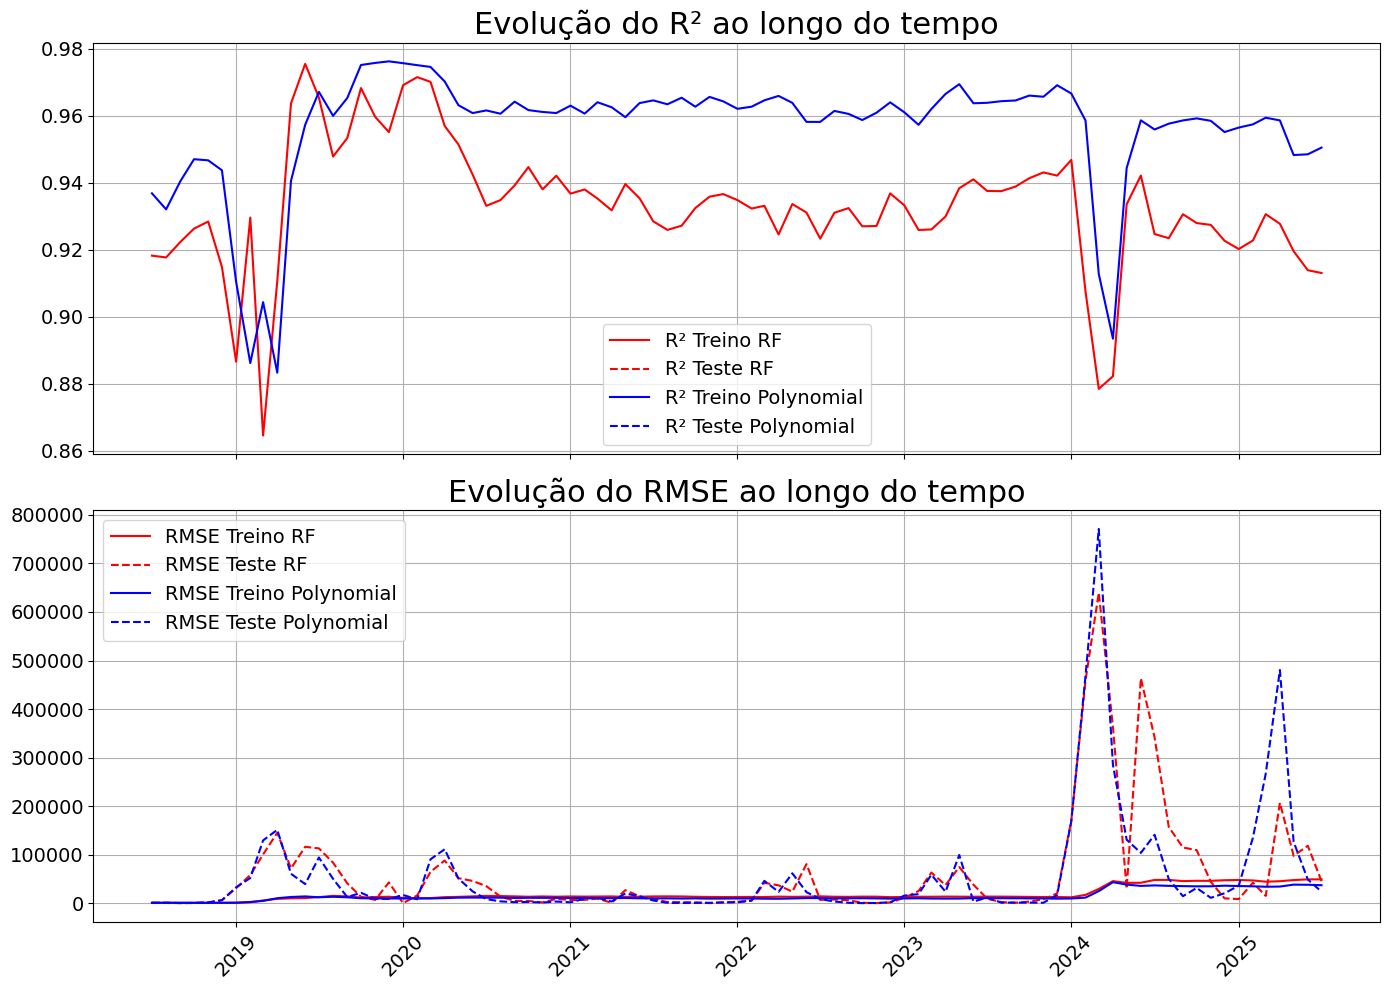

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# Gráfico de R² e RMSE ao longo do tempo
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# R²
axs[0].plot(datas_avaliadas, r2_rf_treino, label='R² Treino RF', color='red')
axs[0].plot(datas_avaliadas, r2_rf_teste, label='R² Teste RF', color='red', linestyle='--')
axs[0].plot(datas_avaliadas, r2_poly_treino, label='R² Treino Polynomial', color='blue')
axs[0].plot(datas_avaliadas, r2_poly_teste, label='R² Teste Polynomial', color='blue', linestyle='--')
axs[0].set_title('Evolução do R² ao longo do tempo')
axs[0].legend()
axs[0].grid(True)

# RMSE
axs[1].plot(datas_avaliadas, rmse_rf_treino, label='RMSE Treino RF', color='red')
axs[1].plot(datas_avaliadas, rmse_rf_teste, label='RMSE Teste RF', color='red', linestyle='--')
axs[1].plot(datas_avaliadas, rmse_poly_treino, label='RMSE Treino Polynomial', color='blue')
axs[1].plot(datas_avaliadas, rmse_poly_teste, label='RMSE Teste Polynomial', color='blue', linestyle='--')
axs[1].set_title('Evolução do RMSE ao longo do tempo')
axs[1].legend()
axs[1].grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('charts/analise_temporal/resultados_evolucao.svg', dpi=600)
plt.show()

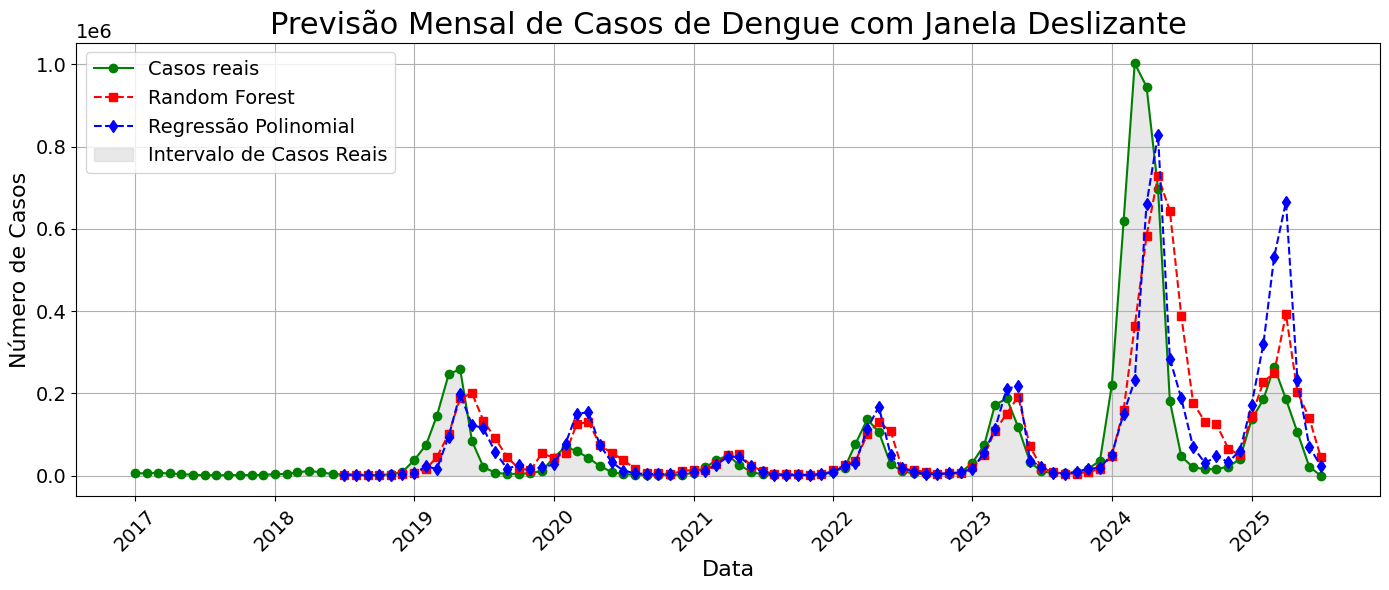

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(df_mensal['data'], df_mensal['casos'], label='Casos reais', marker='o', color='green')
plt.plot(df_resultados['data'], df_resultados['rf'], label='Random Forest', linestyle='--', marker='s', color='red')
plt.plot(df_resultados['data'], df_resultados['polynomial'], label='Regressão Polinomial', linestyle='--', marker='d', color='blue')
plt.fill_between(df_mensal['data'], df_mensal['casos'], color='lightgrey', alpha=0.5, label='Intervalo de Casos Reais')
plt.grid(True)
plt.title('Previsão Mensal de Casos de Dengue com Janela Deslizante')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('charts/analise_temporal/previsao_dengue_mensal.svg', dpi=600)
plt.show()


---

## Prevendo o futuro da dengue no Brasil

A partir do gráfico e dos dados, inferimos um ótimo resultado. Por conta da quantidade anormal de dengue em 2024, os modelos preveram muito mais casos de dengue no verão de 2025 do que de fato houveram, mas o principal que é a sazonalidade da doença foi captado. Decidimos, então, avaliar a maneira como o RandomForest prevê os próximos 60 meses, usando a previsao polinomial como base para estimar os novos dados

---

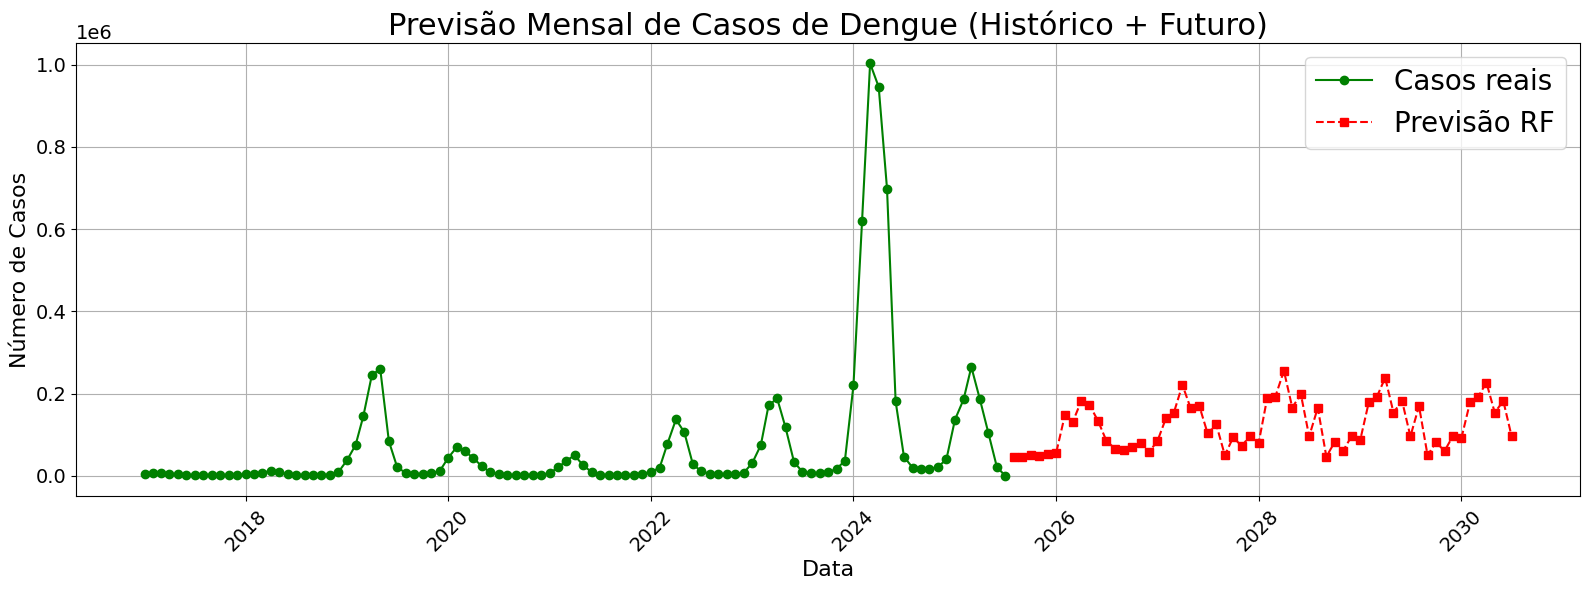

In [29]:
# 1. Última data da base histórica
ultima_data = df_mensal['data'].max()
proximos_meses = pd.date_range(start=ultima_data + pd.DateOffset(months=1), periods=60, freq='MS')

# 2. Histórico recente para iniciar previsão recursiva
dados_hist = df_mensal[['data', 'casos']].copy().set_index('data')

# 3. Função para gerar features
def gerar_features(df):
    df['ano'] = df.index.year
    df['mes'] = df.index.month
    df['trimestre'] = df.index.quarter
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    df['casos_1m'] = df['casos'].shift(1)
    df['casos_3m'] = df['casos'].shift(3)
    df['casos_12m'] = df['casos'].shift(12)
    df['media_movel_3m'] = df['casos'].rolling(3).mean().shift(1)
    df['media_movel_6m'] = df['casos'].rolling(6).mean().shift(1)
    df['media_movel_12m'] = df['casos'].rolling(12).mean().shift(1)
    df['casos_1m_x_mes'] = df['casos_1m'] * df['mes']
    return df

# 4. Loop recursivo
df_futuro = pd.DataFrame(index=proximos_meses, columns=['casos', 'Previsao_RF', 'Previsao_Polynomial'])

for data in proximos_meses:
    df_temp = pd.concat([dados_hist, df_futuro[['casos']]]).sort_index()
    df_feat = gerar_features(df_temp).dropna()
    ultimo = df_feat.loc[[df_feat.index.max()]].copy()

    X_futuro = ultimo[['ano', 'mes', 'trimestre', 'casos_1m', 'casos_3m', 'media_movel_6m', 'media_movel_12m',
                    'casos_12m', 'media_movel_3m', 'mes_sin', 'mes_cos', 'casos_1m_x_mes']]

    prev_rf = modelo_rf.predict(X_futuro)[0]
    prev_polynomial = modelo_polynomial.predict(X_futuro)[0]

    df_futuro.at[data, 'Previsao_RF'] = prev_rf
    df_futuro.at[data, 'Previsao_Polynomial'] = prev_polynomial
    df_futuro.at[data, 'casos'] = prev_polynomial

df_futuro.reset_index(inplace=True)
df_futuro.rename(columns={'index': 'data'}, inplace=True)

plt.figure(figsize=(16, 6))

plt.plot(df_mensal['data'], df_mensal['casos'], label='Casos reais', marker='o', color='green')

plt.plot(df_futuro['data'], df_futuro['Previsao_RF'], label='Previsão RF', linestyle='--', marker='s', color='red')


plt.title('Previsão Mensal de Casos de Dengue (Histórico + Futuro)')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig('charts/analise_temporal/previsao_dengue_futuro.svg', dpi=600)
plt.show()



---

Usamos o `geopandas` para mostrar a distribuição de dengue no período, por estado do sudeste

---

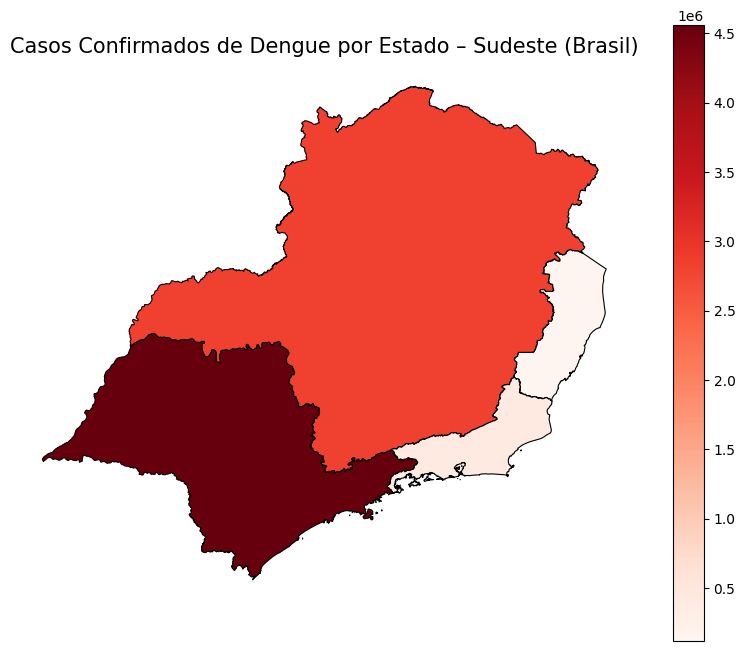

In [15]:
import geopandas as gpd

brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

brasil['name'] = brasil['name'].str.upper()

sudeste_estados = ['SÃO PAULO', 'RIO DE JANEIRO', 'MINAS GERAIS', 'ESPÍRITO SANTO']
sudeste = brasil[brasil['name'].isin(sudeste_estados)].copy()

codigo_para_estado = {
    35: 'SÃO PAULO',
    33: 'RIO DE JANEIRO',
    31: 'MINAS GERAIS',
    32: 'ESPÍRITO SANTO'
}
df['estado_nome'] = df['sg_uf'].map(codigo_para_estado)

dados_dengue = df.groupby('estado_nome').size().reset_index(name='casos_dengue')

sudeste = sudeste.merge(dados_dengue, left_on='name', right_on='estado_nome', how='left')
sudeste['casos_dengue'] = sudeste['casos_dengue'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sudeste.plot(column='casos_dengue',
             cmap='Reds',
             linewidth=0.8,
             edgecolor='black',
             legend=True,
             ax=ax)

plt.title('Casos Confirmados de Dengue por Estado – Sudeste (Brasil)', fontsize=15)
plt.axis('off')
plt.show()